In [1]:
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.datasets import mnist
import numpy as np

2024-03-21 09:00:10.746387: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-21 09:00:10.779208: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-21 09:00:10.779248: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-21 09:00:10.779822: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-21 09:00:10.783713: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Check tensorflow device
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 306356702581306293
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22328377344
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14670038447523753277
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


2024-03-21 09:00:12.717429: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-21 09:00:12.753902: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-21 09:00:12.753944: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-21 09:00:13.826548: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-21 09:00:13.826601: I external/local_xla/xla/stream_executor

In [3]:
# hipermarametros

batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 100
epsilon_std = 0.7

In [4]:
# create incoder

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation="relu")(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)
z = Lambda(
    lambda args: args[0]
    + K.random_normal(
        shape=(K.shape(args[0])[0], latent_dim), mean=0.0, stddev=epsilon_std
    )
    * K.exp(args[1] / 2),
    output_shape=(latent_dim,),
)([z_mean, z_log_var])

encoder = Model(x, [z_mean, z_log_var, z], name="encoder")

2024-03-21 09:00:13.845957: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-21 09:00:13.846027: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-21 09:00:13.846045: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-21 09:00:13.846192: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-21 09:00:13.846210: I external/local_xla/xla/stream_executor

In [5]:
# create sampling function


def sampling(args: tuple):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim), mean=0.0, stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [6]:
# create decoder

input_decoder = Input(shape=(latent_dim,), name="decoder_input")

decoder_h = Dense(intermediate_dim, activation="relu", name="decoder_h")(input_decoder)

x_decoded = Dense(original_dim, activation="sigmoid", name="flat_decoded")(decoder_h)

decoder = Model(input_decoder, x_decoded, name="decoder")

In [7]:
# create vae
output_combined = decoder(encoder(x)[2])
vae = Model(x, output_combined)
vae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               201988    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               202256    
                                                                 
Total params: 404244 (1.54 MB)
Trainable params: 404244 (1.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
# loss function
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

vae.add_loss(K.mean(kl_loss) / original_dim)
vae.compile(optimizer="rmsprop", loss="binary_crossentropy")

In [9]:
# dataloads

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [10]:
# train
vae.fit(
    x_train,
    x_train,
    shuffle=True,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, x_test),
)

Epoch 1/100


2024-03-21 09:00:15.985229: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fb81cedb490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-21 09:00:15.985259: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-03-21 09:00:15.988156: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-21 09:00:16.166068: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8800


  1/600 [..............................] - ETA: 15:32 - loss: 0.6939

I0000 00:00:1710979216.187691  424908 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


600/600 [==============================] - 4s 4ms/step - loss: 0.2849 - val_loss: 0.2460
Epoch 2/100
600/600 [==============================] - 2s 3ms/step - loss: 0.2428 - val_loss: 0.2386
Epoch 3/100
600/600 [==============================] - 2s 4ms/step - loss: 0.2374 - val_loss: 0.2343
Epoch 4/100
600/600 [==============================] - 2s 3ms/step - loss: 0.2337 - val_loss: 0.2307
Epoch 5/100
600/600 [==============================] - 2s 4ms/step - loss: 0.2304 - val_loss: 0.2279
Epoch 6/100
600/600 [==============================] - 2s 3ms/step - loss: 0.2280 - val_loss: 0.2261
Epoch 7/100
600/600 [==============================] - 2s 4ms/step - loss: 0.2262 - val_loss: 0.2243
Epoch 8/100
600/600 [==============================] - 2s 4ms/step - loss: 0.2247 - val_loss: 0.2229
Epoch 9/100
600/600 [==============================] - 2s 4ms/step - loss: 0.2234 - val_loss: 0.2217
Epoch 10/100
600/600 [==============================] - 2s 4ms/step - loss: 0.2222 - val_loss: 0.2208
E

1/1 [==============================] - 0s 11ms/step


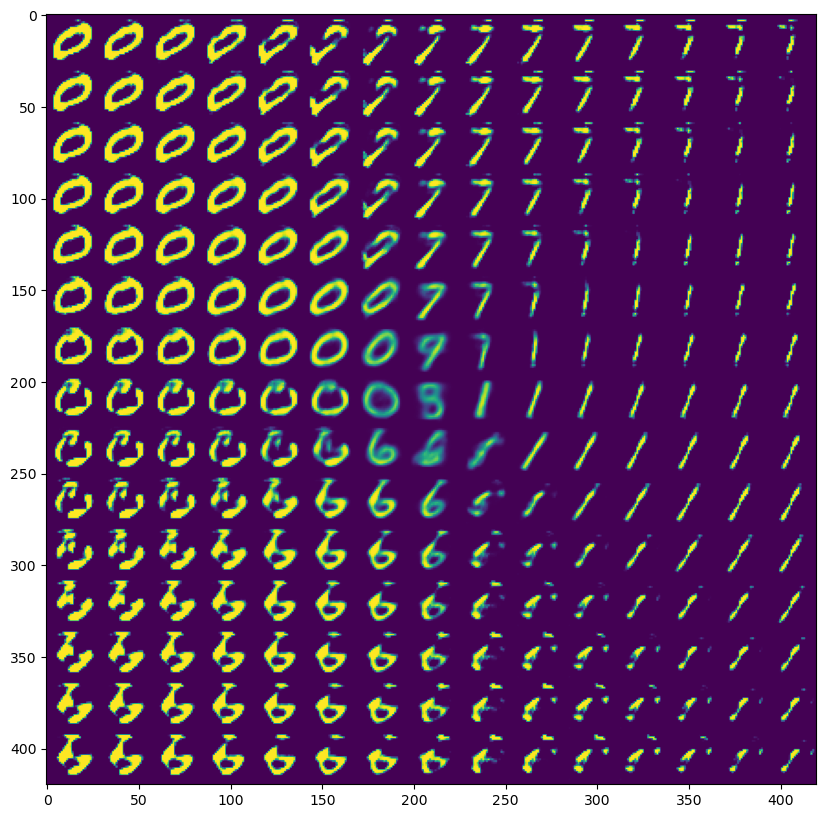

In [11]:
# show results
import matplotlib.pyplot as plt

n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[
            i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size
        ] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()